In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pyBigWig as pbw
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def bw_to_df(bwfile, chroms, valuename, binsize = 20000):
    bw = pbw.open(bwfile)
    df = pd.DataFrame(
        columns = ['chrom', 'start', 'end', valuename]
    )
    for chrom in chroms:
        intervals = []
        for start, end, value in bw.intervals(chrom):
            if (end - start) > binsize:
                intervals.extend(
                    [(chrom, pos, pos + binsize, value) for pos in range(start, end, binsize)]
                )
            
            else:
                intervals.append((chrom, start, end, value))
            
        chrom_df = pd.DataFrame(
            intervals,
            columns = ['chrom', 'start', 'end', valuename]
        )
        df = pd.concat(
            [df, chrom_df]
        )
    bw.close()
    return df

In [3]:
pcfiles = {
    'shLacZ': '/groups/pavri/bioinfo/mihaela/HiC/analysis_rif/ditag/CH12_HiC_shLacZ/CH12_HiC_shLacZ_20kb_w200000.PC1.sort.bedGraph',
    'shMcm': '/groups/pavri/bioinfo/mihaela/HiC/analysis_rif/ditag/CH12_HiC_shMcm/CH12_HiC_shMcm_20kb_w200000.PC1.sort.bedGraph',
    'Rif1ko': '/groups/pavri/bioinfo/mihaela/HiC/analysis_rif/ditag/CH12_HiC_Rif1ko/CH12_HiC_Rif1ko_20kb_w200000.PC1.sort.bedGraph',
    'Rif1ko_shMcm': '/groups/pavri/bioinfo/mihaela/HiC/analysis_rif/ditag/CH12_HiC_Rif1ko_shMcm/CH12_HiC_Rif1ko_shMcm_20kb_w200000.PC1.sort.bedGraph'
}
rtfiles = {
    'Rif1ko_tc': '/groups/pavri/bioinfo/mihaela/RepliSeq/mcmkd_timecourse/repliseq-nf/results20kb/bedGraph/timecourse.Rif1ko.loess.bedGraph',
    'shLacZ_tc': '/groups/pavri/bioinfo/mihaela/RepliSeq/mcmkd_timecourse/repliseq-nf/results20kb/bedGraph/timecourse.WT.loess.bedGraph',
    'shMcm_d5': '/groups/pavri/bioinfo/mihaela/RepliSeq/mcmkd_timecourse/repliseq-nf/results20kb/bedGraph/timecourse.Mcm6kd.d5.loess.bedGraph',
    'Rif1ko_shMcm_d5': '/groups/pavri/bioinfo/mihaela/RepliSeq/mcmkd_timecourse/repliseq-nf/results20kb/bedGraph/timecourse.Mcm6kdRif1ko.d5.loess.bedGraph',
}
corresponding_pc = {
    'Rif1ko_tc': 'Rif1ko',
    'shLacZ_tc': 'shLacZ',
    'shMcm_d5': 'shMcm',
    'Rif1ko_shMcm_d5': 'Rif1ko_shMcm',
}
corrdata = {
    'proseq': '/groups/pavri/bioinfo/mihaela/HiC/analysis_rif/bigwigs20kb/proseq_shLacZ.bw',
}
bgs = {}
for cond in rtfiles.keys():
    print(cond)
    rt = pd.read_csv(rtfiles[cond], sep = '\t', header = None, names = ['chrom', 'start', 'end', 'rt'])
    pc = pd.read_csv(pcfiles[corresponding_pc[cond]], sep = '\t', header = None, names = ['chrom', 'start', 'end', 'pc'])
    df = rt.merge(pc, on = ['chrom', 'start', 'end'], how = 'inner')
    for valuename, bwfile in corrdata.items():
        tmp = bw_to_df(
            bwfile,
            df.chrom.unique(),
            valuename,
            20000
        )
        df = df.merge(
            tmp,
            on = ['chrom', 'start', 'end'],
            how = 'inner'
        )
    
    bgs[cond] = df
bgs['shLacZ_tc']

Rif1ko_tc
shLacZ_tc
shMcm_d5
Rif1ko_shMcm_d5


chrom      start        end        rt        pc      proseq
0       chr1    3000000    3020000 -2.237077 -0.380700    0.451928
1       chr1    3020000    3040000 -2.300855 -0.376417    0.000000
2       chr1    3040000    3060000 -2.349630 -0.371868    0.451928
3       chr1    3060000    3080000 -2.384971 -0.384313    0.451928
4       chr1    3080000    3100000 -2.405667 -0.396566    1.355780
...      ...        ...        ...       ...       ...         ...
125639  chrX  166380000  166400000  1.796273  1.668192  747.940979
125640  chrX  166400000  166420000  1.699354  1.651818  801.719971
125641  chrX  166420000  166440000  1.613159  1.639803  871.317017
125642  chrX  166440000  166460000  1.530235  1.616187  208.339005
125643  chrX  166500000  166520000  1.431266  1.431294    0.000000

[125644 rows x 6 columns]

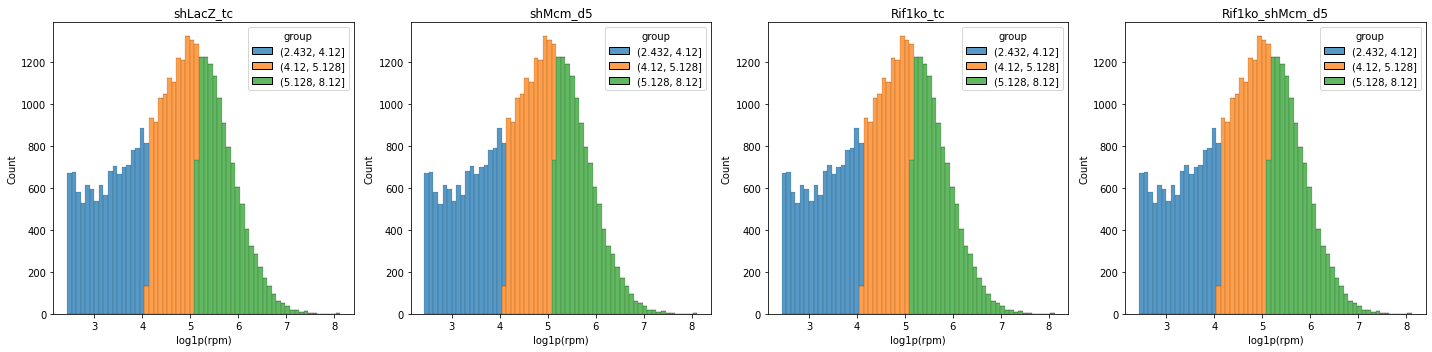

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

conditions = ['shLacZ_tc', 'shMcm_d5', 'Rif1ko_tc', 'Rif1ko_shMcm_d5']
fig, axs = plt.subplots(1, len(conditions))
for ax, condition in zip(axs, conditions):
    data = bgs[condition].copy()
    data = data.loc[data.proseq >= 10, :]
    data.loc[:, 'proseq'] = np.log1p(data.proseq)
    # essentially yields the same result as qcut
    # percentiles = np.percentile(
    #     data.proseq,
    #     np.linspace(0, 100, 5)
    # )
    # data['group'] = np.digitize(
    #     data.proseq,
    #     percentiles
    # )
    data['group'] = pd.qcut(data.proseq, 3)
    sns.histplot(
        data = data,
        x = 'proseq',
        ax = ax,
        hue = 'group',
        multiple = 'stack'
    )
    ax.set_title(condition)
    ax.set_xlabel('log1p(rpm)')
    
    
fig.set_figwidth(20) 
fig.set_figheight(5)
fig.tight_layout()
fig.savefig('proseq_distribution.pdf')

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater_equal
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater_equal
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater_equal
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater_equal


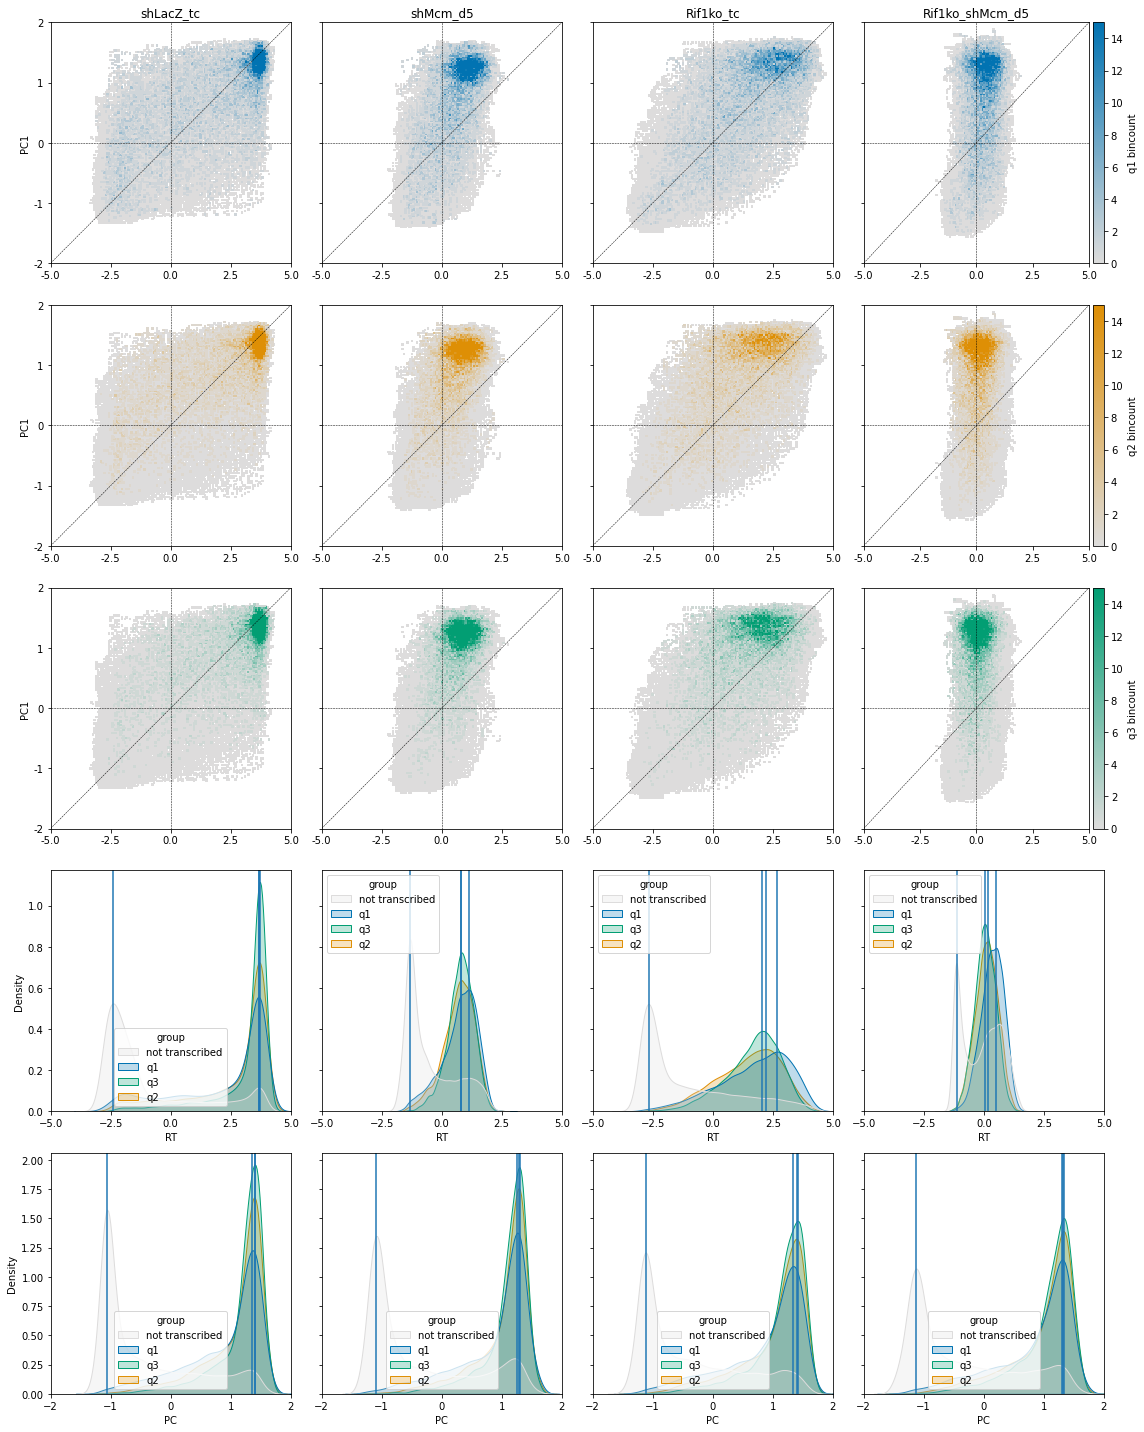

In [6]:
from scipy.stats import binned_statistic_2d
from matplotlib import colors
import seaborn as sns
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
from matplotlib.collections import PolyCollection


def get_kde_modes(ax, kde_axis = 0):
    modes = []
    mode_axis = 0 if kde_axis == 1 else 1
    for child in ax.get_children():
        if not isinstance(child, PolyCollection):
            continue
        
        vertices = child.get_paths()[0]._vertices
        mode_idx = np.argmax(vertices[:, kde_axis])
        modes.append(vertices[mode_idx, mode_axis])
    
    return modes


datakeys = [
    'proseq'
]
conditions = ['shLacZ_tc', 'shMcm_d5', 'Rif1ko_tc', 'Rif1ko_shMcm_d5']
n_bins = 150
#cmap = 'coolwarm'
c_none = plt.get_cmap('coolwarm')(0.5)
npercentiles = 3
groups = [f'q{i+1}' for i in range(npercentiles)]
cmaps = {}
palette = sns.color_palette('colorblind', len(groups))
for i, k in enumerate(groups):
    color = palette[i]
    cmaps[k] = colors.LinearSegmentedColormap.from_list(
        k, [c_none, color]
    )

xlims = (-5, 5)
ylims = (-2, 2)
xnorm = interp1d(xlims, (0, n_bins))
ynorm = interp1d(ylims, (0, n_bins))

cmap = colors.LinearSegmentedColormap.from_list(
    'bla', 
    plt.get_cmap('coolwarm')(np.linspace(0.5, 1, 256))
)
vmin, vmax = 0, 15
for _, key in enumerate(datakeys):
    fig, axs = plt.subplots(
        len(groups) + 2,
        len(conditions),
        sharey = 'row'
    )
    transcription_threshold = 10 if key == 'proseq' else 1
    for j, cond in enumerate(conditions):
        statistic, _, _, _ = binned_statistic_2d(
            x = bgs[cond].rt,
            y = bgs[cond].pc,
            values = bgs[cond][key],
            statistic = np.nanmedian,
            bins = n_bins,
            range = [xlims, ylims]
        )
    
        
        values = bgs[cond].loc[:, ['rt', 'pc', key]]
        # values = values.loc[(values.gene_overlap == 1) & (values[key] >= 1), :].copy()
        values = values.loc[(values[key] >= transcription_threshold), :].copy()
        percentiles = np.percentile(
            values[key],
            np.linspace(0, 100, npercentiles + 1)
        )
        
        values['group'] = np.digitize(
            values[key],
            percentiles
        )
        values.loc[values.group > npercentiles, 'group'] = npercentiles
        
        statistic[statistic >= 0] = 0.5
        for ax, (group_id, value_group) in zip(axs[:-1, j], values.groupby('group')): 

            ax.pcolormesh(
                statistic.T,
                cmap = plt.get_cmap('coolwarm'),
                rasterized = True,
                vmin = 0,
                vmax = 1
            )

            group_statistic, _, _, _ = binned_statistic_2d(
                x = value_group.rt,
                y = value_group.pc,
                values = value_group[key],
                statistic = 'count',
                bins = n_bins,
                range = [xlims, ylims]
            )
            
            group_statistic[group_statistic == 0] = np.nan
            ax.pcolormesh(
                group_statistic.T,
                cmap = cmaps[groups[group_id - 1]],
                rasterized = True,
                vmin = 0,
                vmax = 15
            )
            ax.set_xticks(np.linspace(0, n_bins, 5))
            ax.set_yticks(np.linspace(0, n_bins, 5))
            ax.set_xticklabels(np.linspace(*xlims, 5))
            ax.set_yticklabels(range(ylims[0], ylims[1] + 1, 1))
            ax.axvline(n_bins/2, c='k', lw=0.5, ls='--')
            ax.axhline(n_bins/2, c='k', lw=0.5, ls='--')
            ax.plot([0, n_bins], [0, n_bins], c='k', lw=0.5, ls='--')
            
            if j == 0:
                ax.set_ylabel('PC1')
        
            if j == len(conditions) - 1:
                from mpl_toolkits.axes_grid1 import make_axes_locatable
                divider = make_axes_locatable(ax)
                ax_cb = divider.new_horizontal(size="5%", pad=0.05)
                fig = ax.get_figure()
                fig.add_axes(ax_cb)
                from matplotlib.cm import ScalarMappable
                from matplotlib.colors import Normalize
                plt.colorbar(ScalarMappable(Normalize(vmin, vmax), cmap = cmaps[groups[group_id - 1]]), cax = ax_cb)
                ax_cb.yaxis.tick_right()
                group_label = groups[group_id - 1]
                ax_cb.set_ylabel(f'{group_label} bincount')
            
            if group_id - 1 == 0:
                ax.set_title(cond)
        
        # plot RT/PC kdes
        values.loc[:, 'group'] = values['group'].apply(
            lambda x: groups[x - 1]
        )
        tmp = bgs[cond].loc[:, ['rt', 'pc', key]].copy()
        tmp = tmp.loc[tmp[key] < transcription_threshold, :]
        tmp['group'] = 'not transcribed'
        values = pd.concat(
            [tmp, values]
        )
        color_palette = {
            k: palette[i] for i, k in enumerate(groups)
        }
        color_palette['not transcribed'] = c_none[:-1]
        for ax, col, xlim in zip(axs[-2:, j], ['rt', 'pc'], [(-5, 5), (-2, 2)]):
            sns.kdeplot(
                data = values,
                x = col,
                hue = 'group',
                palette = color_palette,
                fill = True,
                alpha = 0.25,
                legend = True,
                ax = ax,
                common_norm = False
            )

            for mode in get_kde_modes(ax, kde_axis = 1):
                ax.axvline(mode)

            ax.set_xlabel(col.upper())
            ax.set_xlim(*xlim)
            ax.set_xticks(np.linspace(*xlim, 5))
        
    fig.set_figwidth(4 * len(conditions))
    fig.set_figheight(4 * (len(groups) + 2))
    fig.tight_layout()

In [8]:
def expand_bins(df, resolution, value_col):
    df = df.copy()
    expandables = (df.end - df.start) > resolution
    expanded = []
    for i, bin_ in df[expandables].iterrows():
        for j in range((bin_['end'] - bin_['start'])//resolution):
            expanded.append([bin_['chrom'], 
                             bin_['start'] + resolution*j, 
                             bin_['start'] + resolution*(j+1), bin_[value_col]])
            
    df.drop(df[expandables].index, axis = 'index', inplace = True)
    
    expandedDf = pd.DataFrame(expanded,
                              columns = ['chrom', 'start', 'end', value_col])
    
    df = df.merge(expandedDf, 
                  on = ['chrom', 'start', 'end'], 
                  how = 'outer',
                  sort = True) \
           .rename(columns = {value_col + '_x': value_col})
    
    df.loc[:, value_col] = df[value_col].fillna(df[value_col + '_y'])
    return df.drop(value_col + '_y', axis = 'columns')


laczhmm = pd.read_csv(
    '/groups/pavri/bioinfo/mihaela/HiC/analysis_rif/hmm/CH12_shLacZ_tc_RT_3_state_HMM_colored.bed',
    sep = '\t',
    usecols = [0, 1, 2, 3],
    names = ['chrom', 'start', 'end', 'partition']
)

laczhmm = expand_bins(
    laczhmm,
    20_000,
    'partition'
)
partition_to_state = {
    0: 'L',
    1: 'M',
    2: 'E'
}
laczhmm['state'] = laczhmm.partition.apply(
    lambda x: partition_to_state[x]
)
for k, bg in bgs.items():
    # bg.drop(
    #     columns = ['partition', 'state'],
    #     inplace = True
    # )
    bgs[k] = bg.merge(
        laczhmm,
        on = ['chrom', 'start', 'end'],
        how = 'left'
    )

In [9]:
bgs['shLacZ_tc']

chrom      start        end        rt        pc      proseq  partition  \
0       chr1    3000000    3020000 -2.237077 -0.380700    0.451928        0.0   
1       chr1    3020000    3040000 -2.300855 -0.376417    0.000000        0.0   
2       chr1    3040000    3060000 -2.349630 -0.371868    0.451928        0.0   
3       chr1    3060000    3080000 -2.384971 -0.384313    0.451928        0.0   
4       chr1    3080000    3100000 -2.405667 -0.396566    1.355780        0.0   
...      ...        ...        ...       ...       ...         ...        ...   
125639  chrX  166380000  166400000  1.796273  1.668192  747.940979        1.0   
125640  chrX  166400000  166420000  1.699354  1.651818  801.719971        1.0   
125641  chrX  166420000  166440000  1.613159  1.639803  871.317017        1.0   
125642  chrX  166440000  166460000  1.530235  1.616187  208.339005        1.0   
125643  chrX  166500000  166520000  1.431266  1.431294    0.000000        1.0   

       state  
0          L  
1          L  
2          L  
3          L  
4          L  
...      ...  
125639     M  
125640     M  
125641     M  
125642     M  
125643     M  

[125644 rows x 8 columns]

<AxesSubplot:xlabel='state', ylabel='rt'>

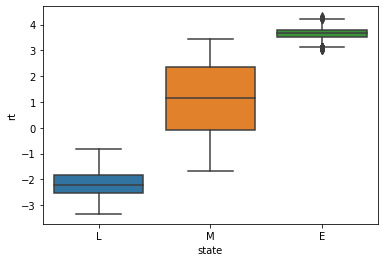

In [11]:
import seaborn as sns
sns.boxplot(
    data = bgs['shLacZ_tc'],
    y = 'rt',
    x = 'state'
)

In [12]:
key = 'proseq'
npercentiles = 3
transcription_threshold = 10
values = bgs['shLacZ_tc'].loc[:, ['chrom', 'start', 'end', 'rt', key, 'state']]
# values = values.loc[(values.gene_overlap == 1) & (values[key] >= 1), :].copy()
values = values.loc[values.state == 'E', :]
values_not_transcribed = values.loc[(values[key] < transcription_threshold), :].copy()
values_transcribed = values.loc[(values[key] >= transcription_threshold), :].copy()
percentiles = np.percentile(
    values_transcribed[key],
    np.linspace(0, 100, npercentiles + 1)
)

values_transcribed['group'] = np.digitize(
    values_transcribed[key],
    percentiles
)
values_transcribed.loc[values_transcribed.group > npercentiles, 'group'] = npercentiles
values_not_transcribed['group'] = npercentiles + 1

values = pd.concat([values_not_transcribed, values_transcribed])
name_map = {
    1: 'low',
    2: 'mid',
    3: 'high',
    4: 'none'
}
values['group_named'] = values.group.apply(
    lambda x: name_map[x]
)
for group, group_df in values.groupby('group_named'):
    group_df = group_df.sort_values(
        by = 'proseq',
        ascending = False
    )
    group_df[['chrom', 'start', 'end']].to_csv(
        f'/groups/pavri/bioinfo/mihaela/HiC/analysis_rif/hmm/lacz_tc_E_{group}.proseqsort.bed',
        sep = '\t',
        header = False,
        index = False
    )

In [13]:
values = bgs['shLacZ_tc'].loc[:, ['chrom', 'start', 'end', 'rt', 'state']]
values

chrom      start        end        rt state
0       chr1    3000000    3020000 -2.237077     L
1       chr1    3020000    3040000 -2.300855     L
2       chr1    3040000    3060000 -2.349630     L
3       chr1    3060000    3080000 -2.384971     L
4       chr1    3080000    3100000 -2.405667     L
...      ...        ...        ...       ...   ...
125639  chrX  166380000  166400000  1.796273     M
125640  chrX  166400000  166420000  1.699354     M
125641  chrX  166420000  166440000  1.613159     M
125642  chrX  166440000  166460000  1.530235     M
125643  chrX  166500000  166520000  1.431266     M

[125644 rows x 5 columns]

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater_equal
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater_equal
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater_equal
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater_equal


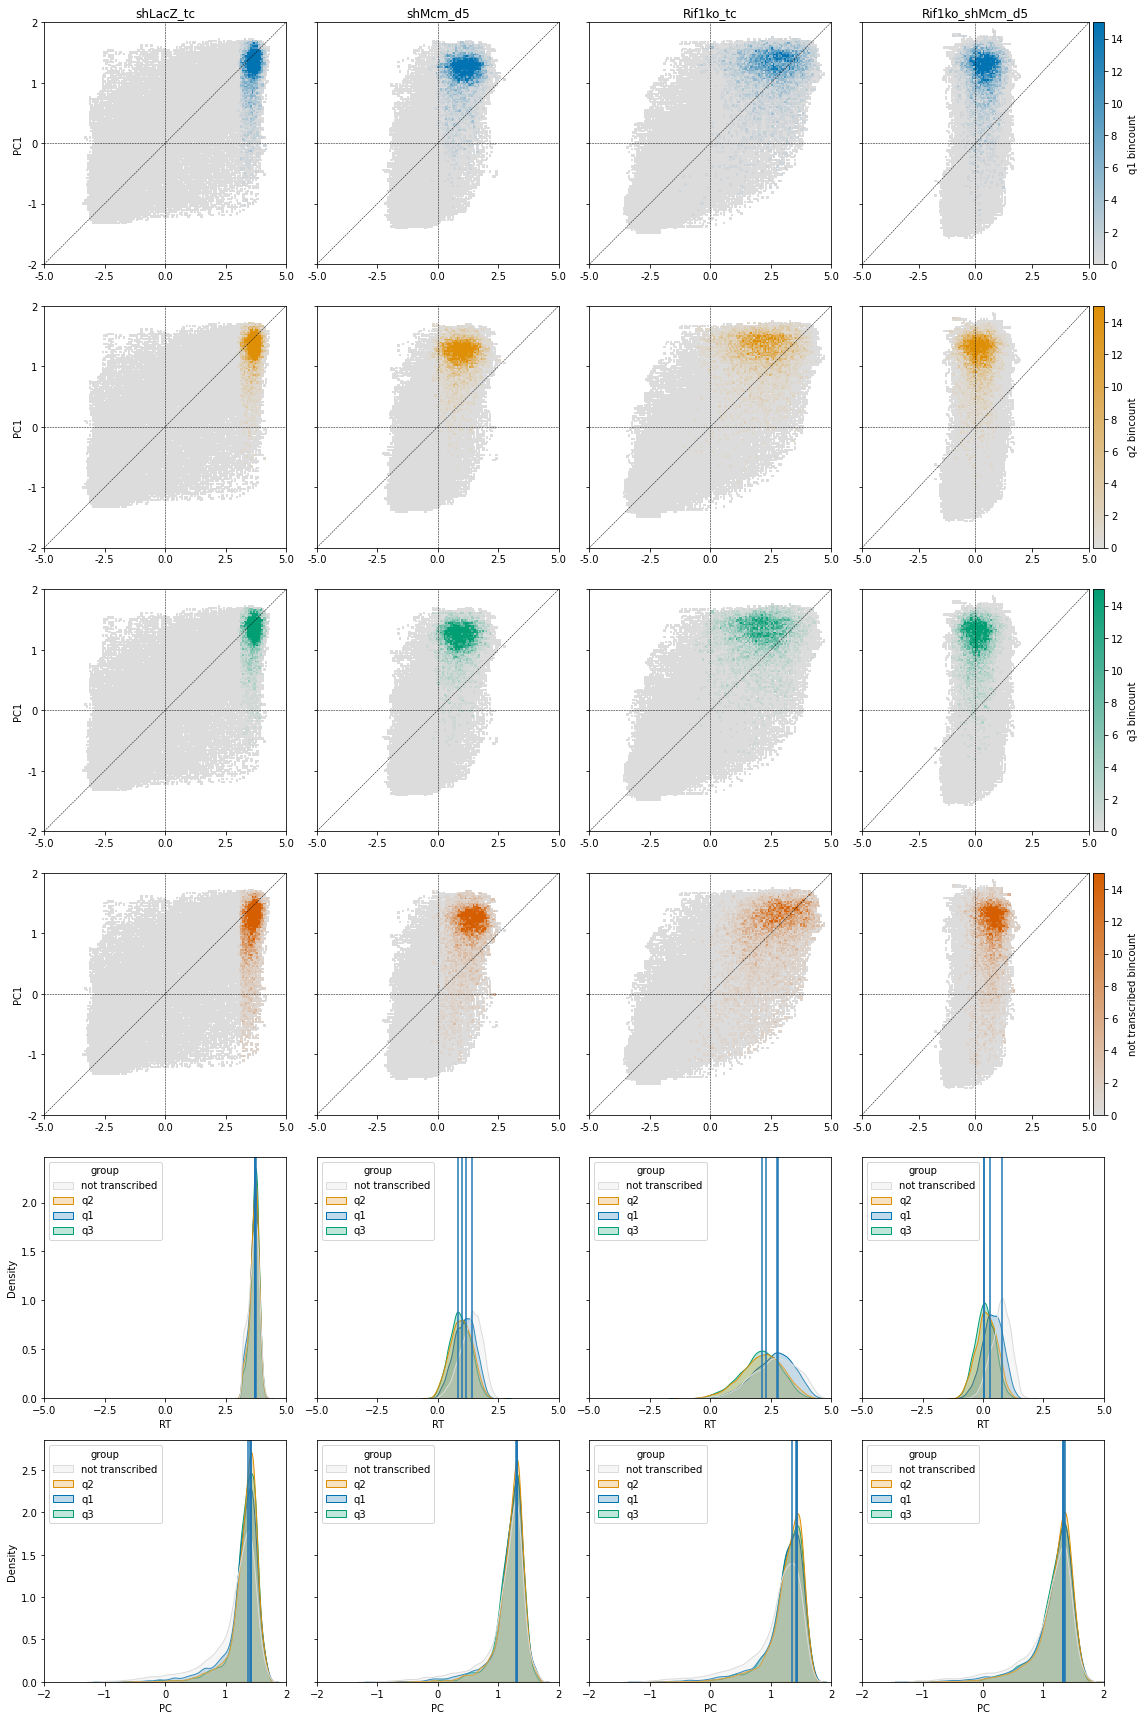

In [14]:
from scipy.stats import binned_statistic_2d
from matplotlib import colors
import seaborn as sns
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
from matplotlib.collections import PolyCollection


def get_kde_modes(ax, kde_axis = 0):
    modes = []
    mode_axis = 0 if kde_axis == 1 else 1
    for child in ax.get_children():
        if not isinstance(child, PolyCollection):
            continue
        
        vertices = child.get_paths()[0]._vertices
        mode_idx = np.argmax(vertices[:, kde_axis])
        modes.append(vertices[mode_idx, mode_axis])
    
    return modes


datakeys = [
    'proseq'
]
conditions = ['shLacZ_tc', 'shMcm_d5', 'Rif1ko_tc', 'Rif1ko_shMcm_d5']
n_bins = 150
#cmap = 'coolwarm'
c_none = plt.get_cmap('coolwarm')(0.5)
npercentiles = 3
groups = [f'q{i+1}' for i in range(npercentiles)] + ['not transcribed']
cmaps = {}
palette = sns.color_palette('colorblind', len(groups))
for i, k in enumerate(groups):
    color = palette[i]
    cmaps[k] = colors.LinearSegmentedColormap.from_list(
        k, [c_none, color]
    )

xlims = (-5, 5)
ylims = (-2, 2)
xnorm = interp1d(xlims, (0, n_bins))
ynorm = interp1d(ylims, (0, n_bins))

cmap = colors.LinearSegmentedColormap.from_list(
    'bla', 
    plt.get_cmap('coolwarm')(np.linspace(0.5, 1, 256))
)
vmin, vmax = 0, 15
for _, key in enumerate(datakeys):
    fig, axs = plt.subplots(
        len(groups) + 2,
        len(conditions),
        sharey = 'row'
    )
    transcription_threshold = 10 if key == 'proseq' else 1
    for j, cond in enumerate(conditions):
        statistic, _, _, _ = binned_statistic_2d(
            x = bgs[cond].rt,
            y = bgs[cond].pc,
            values = bgs[cond][key],
            statistic = np.nanmedian,
            bins = n_bins,
            range = [xlims, ylims]
        )
    
        
        values = bgs[cond].loc[:, ['rt', 'pc', key, 'state']]
        # values = values.loc[(values.gene_overlap == 1) & (values[key] >= 1), :].copy()
        values = values.loc[values.state == 'E', :]
        values_not_transcribed = values.loc[(values[key] < transcription_threshold), :].copy()
        values_transcribed = values.loc[(values[key] >= transcription_threshold), :].copy()
        percentiles = np.percentile(
            values_transcribed[key],
            np.linspace(0, 100, npercentiles + 1)
        )
        
        values_transcribed['group'] = np.digitize(
            values_transcribed[key],
            percentiles
        )
        values_transcribed.loc[values_transcribed.group > npercentiles, 'group'] = npercentiles
        values_not_transcribed['group'] = npercentiles + 1
        
        values = pd.concat([values_not_transcribed, values_transcribed])
        
        statistic[statistic >= 0] = 0.5
        for ax, (group_id, value_group) in zip(axs[:-1, j], values.groupby('group')): 

            ax.pcolormesh(
                statistic.T,
                cmap = plt.get_cmap('coolwarm'),
                rasterized = True,
                vmin = 0,
                vmax = 1
            )

            group_statistic, _, _, _ = binned_statistic_2d(
                x = value_group.rt,
                y = value_group.pc,
                values = value_group[key],
                statistic = 'count',
                bins = n_bins,
                range = [xlims, ylims]
            )
            
            group_statistic[group_statistic == 0] = np.nan
            ax.pcolormesh(
                group_statistic.T,
                cmap = cmaps[groups[group_id - 1]],
                rasterized = True,
                vmin = 0,
                vmax = 15
            )
            ax.set_xticks(np.linspace(0, n_bins, 5))
            ax.set_yticks(np.linspace(0, n_bins, 5))
            ax.set_xticklabels(np.linspace(*xlims, 5))
            ax.set_yticklabels(range(ylims[0], ylims[1] + 1, 1))
            ax.axvline(n_bins/2, c='k', lw=0.5, ls='--')
            ax.axhline(n_bins/2, c='k', lw=0.5, ls='--')
            ax.plot([0, n_bins], [0, n_bins], c='k', lw=0.5, ls='--')
            
            if j == 0:
                ax.set_ylabel('PC1')
        
            if j == len(conditions) - 1:
                from mpl_toolkits.axes_grid1 import make_axes_locatable
                divider = make_axes_locatable(ax)
                ax_cb = divider.new_horizontal(size="5%", pad=0.05)
                fig = ax.get_figure()
                fig.add_axes(ax_cb)
                from matplotlib.cm import ScalarMappable
                from matplotlib.colors import Normalize
                plt.colorbar(ScalarMappable(Normalize(vmin, vmax), cmap = cmaps[groups[group_id - 1]]), cax = ax_cb)
                ax_cb.yaxis.tick_right()
                group_label = groups[group_id - 1]
                ax_cb.set_ylabel(f'{group_label} bincount')
            
            if group_id - 1 == 0:
                ax.set_title(cond)
        
        # plot RT/PC kdes
        values.loc[:, 'group'] = values['group'].apply(
            lambda x: groups[x - 1]
        )
        tmp = bgs[cond].loc[:, ['rt', 'pc', key, 'state']].copy()
        tmp = tmp.loc[(tmp[key] < transcription_threshold) & (tmp.state == 'E'), :]
        tmp['group'] = 'not transcribed'
        values = pd.concat(
            [tmp, values]
        )
        color_palette = {
            k: palette[i] for i, k in enumerate(groups)
        }
        color_palette['not transcribed'] = c_none[:-1]
        for ax, col, xlim in zip(axs[-2:, j], ['rt', 'pc'], [(-5, 5), (-2, 2)]):
            sns.kdeplot(
                data = values,
                x = col,
                hue = 'group',
                palette = color_palette,
                fill = True,
                alpha = 0.25,
                legend = True,
                ax = ax,
                common_norm = False
            )

            for mode in get_kde_modes(ax, kde_axis = 1):
                ax.axvline(mode)

            ax.set_xlabel(col.upper())
            ax.set_xlim(*xlim)
            ax.set_xticks(np.linspace(*xlim, 5))
        
    fig.set_figwidth(4 * len(conditions))
    fig.set_figheight(4 * (len(groups) + 2))
    fig.tight_layout()

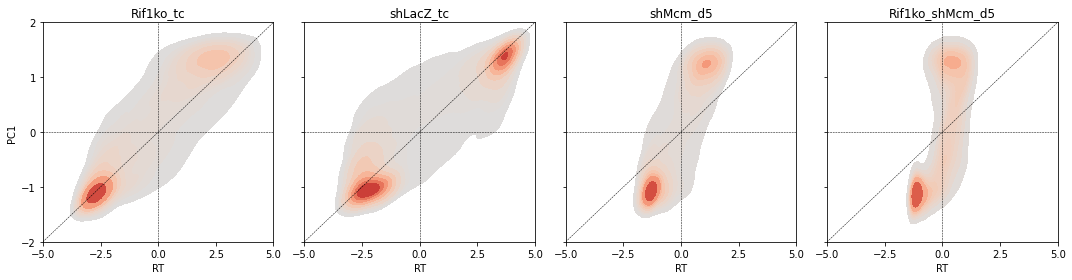

In [15]:
from scipy.stats import binned_statistic_2d
from matplotlib import colors
import seaborn as sns
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d

palette = sns.color_palette('colorblind', 3)
fig, axs = plt.subplots(
    1,
    len(rtfiles), 
    sharex = True, 
    sharey = True
)
n_bins = 150
#cmap = 'coolwarm'
cmap = colors.LinearSegmentedColormap.from_list(
    'bla', 
    plt.get_cmap('coolwarm')(np.linspace(0.5, 1, 256))
)

xlims = (-5, 5)
ylims = (-2, 2)

for j, cond in enumerate(rtfiles.keys()):
    # this is necessary to prevent kdeplot from plotting over existing kdes
    ax = axs[j]
    sns.kdeplot(
        x = bgs[cond].rt,
        y = bgs[cond].pc,
        clip = (xlims, ylims),
        gridsize = 150,
        ax = ax,
        fill = True,
        cmap = cmap
    )

    ax.set_xticks(np.linspace(*xlims, 5))
    ax.set_yticks(np.linspace(*ylims, 5))
    ax.axvline(0, c='k', lw=0.5, ls='--')
    ax.axhline(0, c='k', lw=0.5, ls='--')
    ax.plot(xlims, ylims , c='k', lw=0.5, ls='--')
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)

    if j == 0:
        ax.set_ylabel('PC1')

    ax.set_title(cond)
    ax.set_xlabel('RT')
    
fig.set_figwidth(3.75 * len(rtfiles))
fig.set_figheight(4)
fig.tight_layout()